In [1]:
#%load_ext autoreload
#%autoreload 2
import os
import joblib
import sys

from braindecode.datautil.iterators import get_balanced_batches
from eeggan.examples.conv_cub.model import Generator,Discriminator
from eeggan.util import weight_filler
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
%matplotlib inline


In [2]:
#from mne.io import read_raw_cnt
#raw_fname = '/home/jcuomo/793/04.cnt'
#montage_fname = 'standard-10-5-cap385.elp'
#raw = read_raw_cnt(raw_fname, eog=('HEOG', 'VEOG'), emg=('EMG',), preload=True, verbose=True)

In [58]:
plt.switch_backend('agg')
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
torch.backends.cudnn.enabled=True
torch.backends.cudnn.benchmark=True



n_critic = 2
n_batch = 64
jobid = 0

n_z = 200
lr = 0.001
n_channels = 1
n_blocks = 4
input_length = 12*2**n_blocks
rampup = 200.
block_epochs = [2000]
for i in range(n_blocks-1):
    block_epochs = np.append(block_epochs,4000)

task_ind = 0
np.random.seed(task_ind)
torch.manual_seed(task_ind)
torch.cuda.manual_seed_all(task_ind)
random.seed(task_ind)
rng = np.random.RandomState(task_ind)

#data = os.path.join('/home/jcuomo/793/cba/cba1ff01.dat')
#EEG_data = joblib.load(data)
#train_set = EEG_data['train_set']
#test_set = EEG_data['test_set']
#train = np.concatenate((train_set.X,test_set.X))
#target = np.concatenate((train_set.y,test_set.y))


#train = np.random.rand(1000,1,input_length)
train = np.load('/s/chopin/d/proj/jcuomo/p300.npy')
train = train[:,None,:]

train = train[:,:,:,None]
train = train-train.mean()
train = train/train.std()
train = train/np.abs(train).max()
#target_onehot = np.zeros((target.shape[0],2))
#target_onehot[:,target] = 1

train = train.astype(float)
train.shape

(540, 1, 178, 1, 9)

In [28]:
modelpath = './'
modelname = 'Progressive'
if not os.path.exists(modelpath):
    os.makedirs(modelpath)


generator = Generator(n_channels, n_blocks,n_z)
discriminator = Discriminator(n_channels,n_blocks)

generator.train_init(alpha=lr,betas=(0.,0.99))
discriminator.train_init(alpha=lr,betas=(0.,0.99),eps_center=0.001,
                        one_sided_penalty=True,distance_weighting=True)
generator = generator.apply(weight_filler)
discriminator = discriminator.apply(weight_filler)

i_block_tmp = 0
i_epoch_tmp = 0
generator.model.cur_block = i_block_tmp
discriminator.model.cur_block = n_blocks-1-i_block_tmp
fade_alpha = 1.
generator.model.alpha = fade_alpha
discriminator.model.alpha = fade_alpha

generator = generator.cuda()
discriminator = discriminator.cuda()
generator.train()
discriminator.train()

losses_d = []
losses_g = []
i_epoch = 0
z_vars_im = rng.normal(0,1,size=(100,n_z)).astype(np.float32)

i_block: 3 / 4 , i_epoch: 3900 / 4000
Epoch: 3900   Loss_F: -0.088   Loss_R: -0.028   Penalty: 0.0096   Loss_G: -0.061


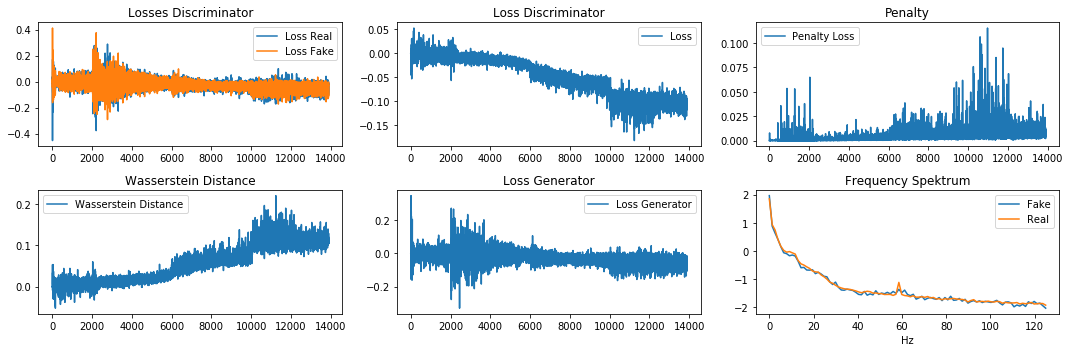

END


In [29]:
%matplotlib inline
for i_block in range(i_block_tmp,n_blocks):
    c = 0
    train_tmp = discriminator.model.downsample_to_block(Variable(torch.from_numpy(train).cuda(),volatile=True),discriminator.model.cur_block).data.cpu()
    for i_epoch in range(i_epoch_tmp,block_epochs[i_block]):
        #print(i_block,i_epoch)
        i_epoch_tmp = 0

        if fade_alpha<1:
            fade_alpha += 1./rampup
            generator.model.alpha = fade_alpha
            discriminator.model.alpha = fade_alpha

        batches = get_balanced_batches(train.shape[0], rng, True, batch_size=n_batch)
        iters = int(len(batches)/n_critic)

        for it in range(iters):
            for i_critic in range(n_critic):
                #print("########### i_block, i_epoch, it, i_critic",i_block, i_epoch, it, i_critic)
                train_batches = train_tmp[batches[it*n_critic+i_critic]]
                batch_real = Variable(train_batches,requires_grad=True).cuda()
                
                z_vars = rng.normal(0,1,size=(len(batches[it*n_critic+i_critic]),n_z)).astype(np.float32)
                z_vars = Variable(torch.from_numpy(z_vars),volatile=True).cuda()
                batch_fake = Variable(generator(z_vars).data,requires_grad=True).cuda()
                loss_d = discriminator.train_batch(batch_real,batch_fake)
                assert np.all([torch.isfinite(ld) for ld in loss_d])
            z_vars = rng.normal(0,1,size=(n_batch,n_z)).astype(np.float32)
            z_vars = Variable(torch.from_numpy(z_vars),requires_grad=True).cuda()
            loss_g = generator.train_batch(z_vars,discriminator)

        losses_d.append(loss_d)
        losses_g.append(loss_g)

        with torch.no_grad():
            if i_epoch%100 == 0:
                clear_output()
                print('i_block:',i_block, '/',n_blocks ,', i_epoch:',i_epoch,'/',block_epochs[i_block])
                generator.eval()
                discriminator.eval()

                print('Epoch: %d   Loss_F: %.3f   Loss_R: %.3f   Penalty: %.4f   Loss_G: %.3f'%(i_epoch,loss_d[0],loss_d[1],loss_d[2],loss_g))
                joblib.dump((i_epoch,losses_d,losses_g),os.path.join(modelpath,modelname+str(jobid)+'_.data'),compress=True)
                joblib.dump((i_epoch,losses_d,losses_g),os.path.join(modelpath,modelname+str(jobid)+'_%d.data'+str(i_epoch)),compress=True)
                #joblib.dump((n_epochs,n_z,n_critic,batch_size,lr),os.path.join(modelpath,modelname%jobid+'_%d.params'%i_epoch),compress=True)

                freqs_tmp = np.fft.rfftfreq(train_tmp.numpy().shape[2],d=1/(250./np.power(2,n_blocks-1-i_block)))

                train_fft = np.fft.rfft(train_tmp.numpy(),axis=2)
                train_amps = np.abs(train_fft).mean(axis=3).mean(axis=0).squeeze()


                z_vars = Variable(torch.from_numpy(z_vars_im),volatile=True).cuda()
                batch_fake = generator(z_vars)
                fake_fft = np.fft.rfft(batch_fake.data.cpu().numpy(),axis=2)
                fake_amps = np.abs(fake_fft).mean(axis=3).mean(axis=0).squeeze()

                plt.close()
                plt.figure(figsize=(15,5))
                plt.subplot(2,3,6)
                plt.plot(freqs_tmp,np.log(fake_amps),label='Fake')
                plt.plot(freqs_tmp,np.log(train_amps),label='Real')
                plt.title('Frequency Spektrum')
                plt.xlabel('Hz')
                plt.legend()
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_fft_%d_%d.png'%(i_block,i_epoch)))

               # for i in range(10):
               #     plt.subplot(10,1,i+1)
               #     plt.plot(batch_fake[i].squeeze())
               #     plt.xticks((),())
               #     plt.yticks((),())
               # plt.subplots_adjust(hspace=0)
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_fakes_%d_%d.png'%(i_block,i_epoch)))
                #plt.close()

                discriminator.save_model(os.path.join(modelpath,modelname+str(jobid)+'.disc'))
                generator.save_model(os.path.join(modelpath,modelname+str(jobid)+'.gen'))

                plt.subplot(2,3,1)
                plt.plot(np.asarray(losses_d)[:,0],label='Loss Real')
                plt.plot(np.asarray(losses_d)[:,1],label='Loss Fake')
                plt.title('Losses Discriminator')
                plt.legend()
                plt.subplot(2,3,2)
                plt.plot(np.asarray(losses_d)[:,0]+np.asarray(losses_d)[:,1]+np.asarray(losses_d)[:,2],label='Loss')
                plt.title('Loss Discriminator')
                plt.legend()
                plt.subplot(2,3,3)
                plt.plot(np.asarray(losses_d)[:,2],label='Penalty Loss')
                plt.title('Penalty')
                plt.legend()
                plt.subplot(2,3,4)
                plt.plot(-np.asarray(losses_d)[:,0]-np.asarray(losses_d)[:,1],label='Wasserstein Distance')
                plt.title('Wasserstein Distance')
                plt.legend()
                plt.subplot(2,3,5)
                plt.plot(np.asarray(losses_g),label='Loss Generator')
                plt.title('Loss Generator')
                plt.legend()
                plt.tight_layout()
                plt.show()
                #plt.savefig(os.path.join(modelpath,modelname+str(jobid)+'_losses.png'))
                #plt.close()

                generator.train()
                discriminator.train()


    fade_alpha = 0.
    generator.model.cur_block += 1
    discriminator.model.cur_block -= 1
print("END")

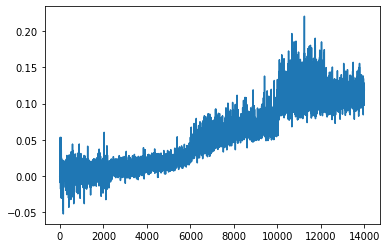

In [55]:
plt.plot(-np.asarray(losses_d)[:,0]-np.asarray(losses_d)[:,1])


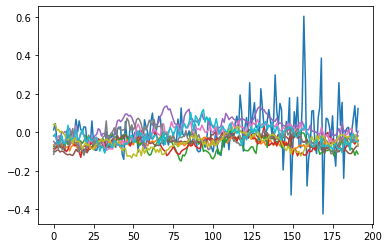

In [30]:
plt.plot(batch_fake[:10].squeeze().cpu().detach().T)
plt.show()

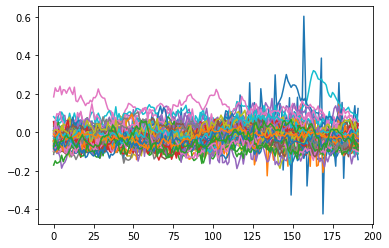

In [32]:
plt.plot(batch_fake[:100].squeeze().cpu().detach().T)
plt.show()

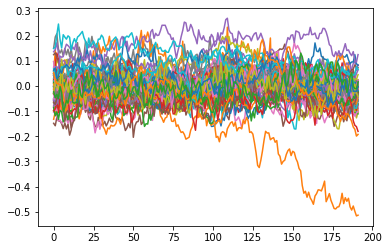

In [33]:
plt.plot(batch_real[:100].squeeze().cpu().detach().T)
plt.show()

In [38]:
rr = batch_real[:100].squeeze().cpu().detach().numpy()
rrm = np.mean(rr,axis=0)

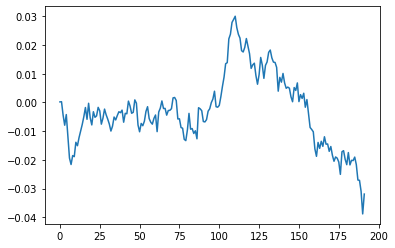

In [40]:
plt.plot(rrm)
plt.show()

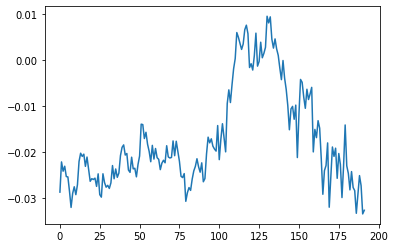

In [56]:
ff = batch_fake[:].squeeze().cpu().detach().numpy()
ffm = np.mean(ff,axis=0)
plt.plot(ffm)
plt.show()

In [57]:
batch_fake.shape

torch.Size([63, 1, 192, 1])